In [1]:
# Imports/setup
!pip install misdeed
import misdeed

import numpy as np
from misdeed.OmicsGenerator import OmicsGenerator
from misdeed.visualization import plot_timecourse, plot_pca
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

np.random.seed(10)

**Power Analysis using MiSDEED**

In this notebook, we analyze MiSDEED's statistical power and investigate the effects of various study parameters on the significance of study results. The following analysis suggests that 1) having at least 30 individuals in the study, or 2) using a read depth of at least 300, or 3) having a time duration of at least 4000 timesteps are sufficient to obtain statistically significant results with high probability.

In [37]:
# Set system parameters
C = 0.4
D =  5
SIGMA =  0.5
RHO = -0.6
TIME_POINTS = 5000
N_CLADES =  30
N_METABOLITES = 45

# Set simulation parameters
TIME_STEP = 1e-2
NOISE_VARIANCE = 1e-2
DOWNSAMPLING_RATE =  100
READS_PER_SAMPLE =  10000

# Set study parameters
N_INDIVIDUALS =  300
EXTINCT_FRACTION = 0
CASE_FRACTION =  0.33333
EFFECT_SIZE =  1

# Set display parameters
ALPHA = 1
PLOT_TRAJECTORIES = False
MARK_ENDPOINTS = True

# Set power analysis parameters
P = 0.05 #fka p_value

In [38]:
# Create the generator
gen = OmicsGenerator(
    node_sizes=[N_CLADES,N_METABOLITES], 
    node_names=['mgx','mbx'],
    time_points=TIME_POINTS,
    init_full=True,
    silent=True,
    C=C,
    d=D,
    sigma=SIGMA,
    rho=RHO
)

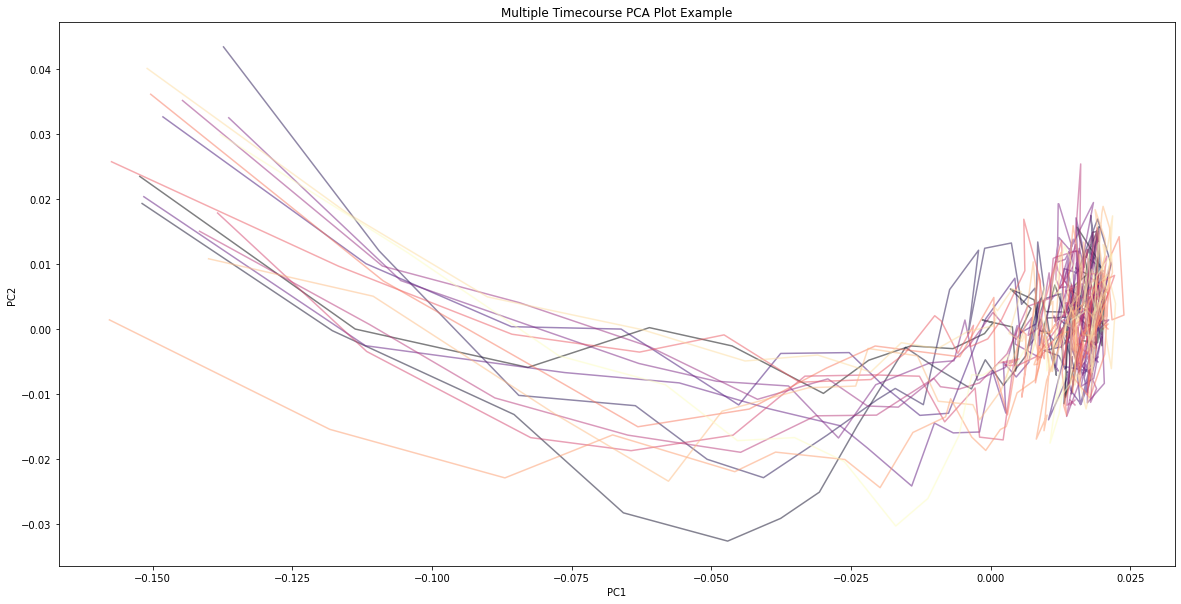

In [40]:
# Multiple sample PCA timecourse example

# Population parameters
N_INDIVIDUALS =  15
EXTINCT_FRACTION = 0

# Display parameters
ALPHA =  0.5
PLOT_TRAJECTORIES = True
MARK_ENDPOINTS = True

x, y, z = gen.generate_multiple(
    n=N_INDIVIDUALS, 
    extinct_fraction=EXTINCT_FRACTION, 
    dt=TIME_STEP, 
    noise_var=NOISE_VARIANCE, 
    downsample=DOWNSAMPLING_RATE,
    n_reads = READS_PER_SAMPLE
)

plt.figure(figsize=(20,10))
plot_pca(
    trajectories=[y], 
    node_name='mgx', 
    alpha=ALPHA, 
    plot_trajectories=PLOT_TRAJECTORIES, 
    plot_endpoints=MARK_ENDPOINTS
)
plt.title("Multiple Timecourse PCA Plot Example")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [6]:
# Generate case-control trajectories

zCtrl, xCtrl, yCtrl, zCs, xCs, yCs = gen.case_control(
    participants=N_INDIVIDUALS,
    case_frac=CASE_FRACTION,
    node_name='mgx',
    effect_size=EFFECT_SIZE,
    extinct_fraction=EXTINCT_FRACTION, 
    dt=TIME_STEP, 
    noise_var=NOISE_VARIANCE, 
    downsample=DOWNSAMPLING_RATE,
    n_reads = READS_PER_SAMPLE
)

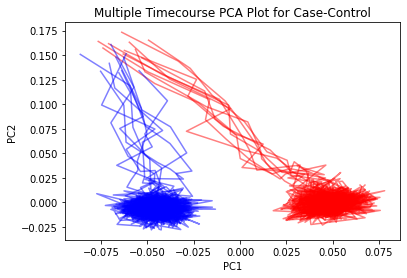

In [35]:
# Plot control (red) vs. case (blue)

plot_pca(
    trajectories=[yCtrl[:len(yCs)],yCs], 
    node_name='mgx', 
    colors=['red', 'blue'],
    plot_endpoints=MARK_ENDPOINTS,
    plot_trajectories=PLOT_TRAJECTORIES,
    alpha=ALPHA
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Multiple Timecourse PCA Plot for Case-Control")
plt.show()

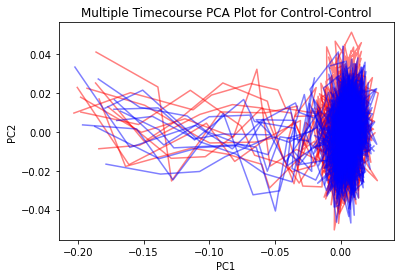

In [21]:
# Plot control vs. control
plot_pca(
    trajectories=[yCtrl[:len(yCs)], yCtrl[len(yCs):]],
    node_name='mgx', 
    colors=['red', 'blue'],
    plot_endpoints=MARK_ENDPOINTS,
    plot_trajectories=PLOT_TRAJECTORIES,
    alpha=ALPHA
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Multiple Timecourse PCA Plot for Control-Control")
plt.show()

The first study parameter we investigate is the number of individuals enrolled in the study. We perform tests on study sizes ranging from one individual to up to almost 300 individuals. We find that given a sufficient read depth and time bound, the number of individuals required for samples to be distinguishable can be as low as 30.

In [43]:
# Varying number of individuals in study
n_individuals = [2**i for i in range(1,9)]
READS_PER_SAMPLE = 1000
y_control_n = []
y_case_n = []

for n in n_individuals:
    zCtrl, xCtrl, yCtrl, zCs, xCs, yCs = gen.case_control(
        participants = n,
        case_frac = CASE_FRACTION,
        node_name = 'mgx',
        effect_size = EFFECT_SIZE,
        extinct_fraction = EXTINCT_FRACTION,
        dt = TIME_STEP,
        noise_var = NOISE_VARIANCE,
        downsample = DOWNSAMPLING_RATE,
        n_reads = READS_PER_SAMPLE
    )
    y_control_n.append(yCtrl)
    y_case_n.append(yCs)

In [44]:
# Calculate p-values for n_individuals
pvals = []
neg_controls = []
for i in range(len(y_control_n)):
    experiment = y_case_n[i]
    control = y_control_n[i]
    w_pvals = []
    w_neg_controls = []

    for k in range(N_CLADES):
        cases = [y['mgx'][:,k] for y in experiment]
        controls = [y['mgx'][:,k] for y in control[:len(cases)-1]]
        controls2 = [y['mgx'][:,k] for y in control[len(cases)-1:]]

        for j in range(len(cases)-1):
            #cases vs. controls
            w,p = wilcoxon(cases[j],controls[j],
                           zero_method='zsplit')
            w_pvals.append(p)

            #control 1 vs. control 2
            w1,p1 = wilcoxon(controls[j],controls2[j],
                             zero_method='zsplit')
            w_neg_controls.append(p1)

    pvals.append(w_pvals)
    neg_controls.append(w_neg_controls)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


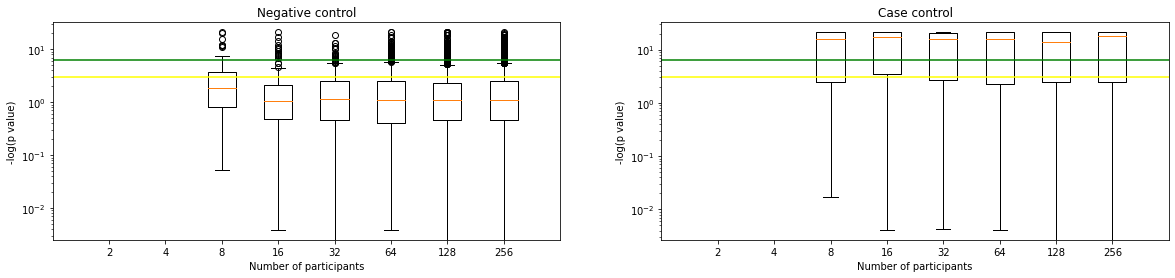

In [45]:
# Plotting case-control significance for n_individuals

fig, axs = plt.subplots(1,2)

axs[0].boxplot([-np.log(neg_controls[i]) for i in range(len(y_control_n))])
axs[0].set_xticklabels(n_individuals)
axs[0].set_title('Negative control')
axs[0].set_xlabel('Number of participants')
axs[0].set_ylabel('-log(p value)')

axs[1].boxplot([-np.log(pvals[i]) for i in range(len(y_control_n))])
axs[1].set_title('Case control')
axs[1].set_xlabel('Number of participants')
axs[1].set_ylabel('-log(p value)')
axs[1].set_xticklabels(n_individuals)

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].axhline(-np.log(P),-10,20,color='yellow')
axs[0].axhline(-np.log(P/N_CLADES),-10,20,color='green')
axs[0].set_xlim(0,len(n_individuals)+1) #n_ind

axs[1].axhline(-np.log(P),-10,20,color='yellow')
axs[1].axhline(-np.log(P/N_CLADES),-10,20,color='green')
axs[1].set_xlim(0,len(n_individuals)+1)

fig.set_figwidth(20)

In [46]:
# Varying read depth
num_individuals = 30
rd = [1+i**4 for i in range(8)]
y_control_r = []
y_case_r = []

for r in rd:
    zCtrl, xCtrl, yCtrl, zCs, xCs, yCs = gen.case_control(
        participants = num_individuals,
        case_frac = CASE_FRACTION,
        node_name = 'mgx',
        effect_size = EFFECT_SIZE,
        extinct_fraction = EXTINCT_FRACTION,
        dt = TIME_STEP,
        noise_var = NOISE_VARIANCE,
        downsample = DOWNSAMPLING_RATE,
        n_reads = r
    )
    y_control_r.append(yCtrl)
    y_case_r.append(yCs)

In [47]:
# Calculate p-values for read depth
pvals = []
neg_controls = []
for i in range(len(y_control_r)):
    experiment = y_case_r[i]
    control = y_control_r[i]
    w_pvals = []
    w_neg_controls = []

    for k in range(N_CLADES):
        cases = [y['mgx'][:,k] for y in experiment]
        controls = [y['mgx'][:,k] for y in control[:len(cases)-1]]
        controls2 = [y['mgx'][:,k] for y in control[len(cases)-1:]]

        for j in range(len(cases)-1):
            #cases vs. controls
            w,p = wilcoxon(cases[j],controls[j],
                           zero_method='zsplit')
            w_pvals.append(p)

            #control 1 vs. control 2
            w1,p1 = wilcoxon(controls[j],controls2[j],
                             zero_method='zsplit')
            w_neg_controls.append(p1)

    pvals.append(w_pvals)
    neg_controls.append(w_neg_controls)

We can observe a clear relationship between read depth and the proportion of statistically significant results. For read depths as low as 300, we begin to see high-quality results with low probability of obtaining false positives. Notably, although read depth increases the probability of obtaining statistically significant results from control-control studies, none cross either the p = 0.05 or the adjusted threshold (approximately p = 0.001).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


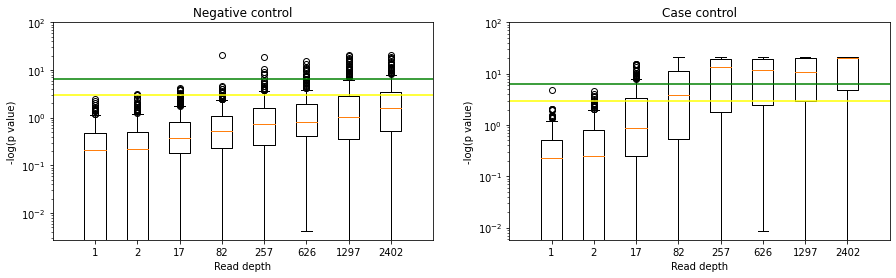

In [48]:
# Plotting case-control significance for read depth

fig, axs = plt.subplots(1,2)

axs[0].boxplot([-np.log(neg_controls[i]) for i in range(len(y_control_r))])
axs[0].set_xticklabels(rd)
axs[0].set_title('Negative control')
axs[0].set_xlabel('Read depth')
axs[0].set_ylabel('-log(p value)')

axs[1].boxplot([-np.log(pvals[i]) for i in range(len(y_control_r))])
axs[1].set_title('Case control')
axs[1].set_xlabel('Read depth')
axs[1].set_ylabel('-log(p value)')
axs[1].set_xticklabels(rd)

axs[0].set_yscale('log')
axs[0].set_ylim(0,100)
axs[1].set_yscale('log')
axs[1].set_ylim(0,100)

axs[0].axhline(-np.log(P),-10,20,color='yellow')
axs[0].axhline(-np.log(P/N_CLADES),-10,20,color='green')
axs[0].set_xlim(0,len(y_control_r)+1)

axs[1].axhline(-np.log(P),-10,20,color='yellow')
axs[1].axhline(-np.log(P/N_CLADES),-10,20,color='green')
axs[1].set_xlim(0,len(y_control_r)+1)

fig.set_figwidth(15)

We observe that increasing the duration of the study increases the likelihood of observing strong distinguishability between samples. A duration of about 3000 timesteps appears to be sufficient.

In [15]:
# Varying timesteps
num_individuals = 30
timesteps = [2**i for i in range(5,15)]
y_control_t = []
y_case_t = []
reads_per_sample = 1000

for t in timesteps:
    gen = OmicsGenerator(
        node_sizes=[N_CLADES,N_METABOLITES], 
        node_names=['mgx','mbx'],
        time_points=t,
        init_full=True,
        silent=True,
        C=C,
        d=D,
        sigma=SIGMA,
        rho=RHO
    )

    zCtrl, xCtrl, yCtrl, zCs, xCs, yCs = gen.case_control(
        participants = num_individuals,
        case_frac = CASE_FRACTION,
        node_name = 'mgx',
        effect_size = EFFECT_SIZE,
        extinct_fraction = EXTINCT_FRACTION,
        dt = TIME_STEP,
        noise_var = NOISE_VARIANCE,
        downsample = DOWNSAMPLING_RATE,
        n_reads = reads_per_sample
    )
    y_control_t.append(yCtrl)
    y_case_t.append(yCs)

In [16]:
# Calculate p-values for timesteps

pvals = []
neg_controls = []
for i in range(len(y_control_t)):
    experiment = y_case_t[i]
    control = y_control_t[i]
    w_pvals = []
    w_neg_controls = []

    for k in range(N_CLADES):
        cases = [y['mgx'][:,k] for y in experiment]
        controls = [y['mgx'][:,k] for y in control[:len(cases)-1]]
        controls2 = [y['mgx'][:,k] for y in control[len(cases)-1:]]

        for j in range(len(cases)-1):
            #cases vs. controls
            w,p = wilcoxon(cases[j],controls[j],
                           zero_method='zsplit')
            w_pvals.append(p)

            #control 1 vs. control 2
            w1,p1 = wilcoxon(controls[j],controls2[j],
                             zero_method='zsplit')
            w_neg_controls.append(p1)

    pvals.append(w_pvals)
    neg_controls.append(w_neg_controls)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


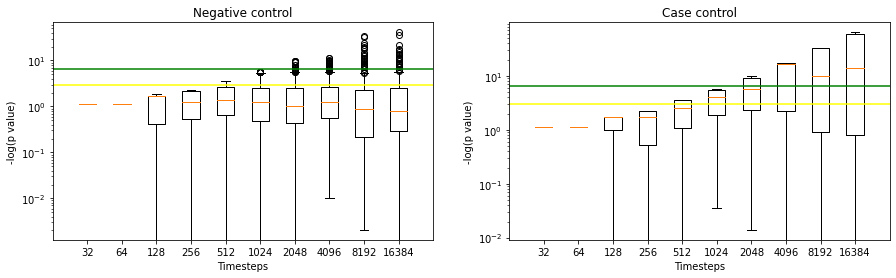

In [42]:
# Plotting case-control significance for timesteps

fig, axs = plt.subplots(1,2)

axs[0].boxplot([-np.log(neg_controls[i]) for i in range(len(y_control_t))])
axs[0].set_xticklabels(timesteps)
axs[0].set_title('Negative control')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('-log(p value)')

axs[1].boxplot([-np.log(pvals[i]) for i in range(len(y_control_t))])
axs[1].set_title('Case control')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('-log(p value)')
axs[1].set_xticklabels(timesteps)

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].axhline(-np.log(P),-10,20,color='yellow')
axs[0].axhline(-np.log(P/N_CLADES),-10,20,color='green')
axs[0].set_xlim(0,len(y_control_t)+1)

axs[1].axhline(-np.log(P),-10,20,color='yellow')
axs[1].axhline(-np.log(P/N_CLADES),-10,20,color='green')
axs[1].set_xlim(0,len(y_control_t)+1)

fig.set_figwidth(15)